# Libraries

In [281]:
import requests

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
import re
import math

#import dtale 

pd.set_option('display.max_columns', None) # display all columns in DF
#pd.set_option('display.max_rows', None) 

# Color Palette

In [282]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [283]:
pal = sns.color_palette("Set2")
pal.as_hex()
print(pal)

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]


# Describing the data

In [284]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
print('Total number of drugs: ', df['unique_id'].nunique())
print('Total numober of brand-name producers: ', df['labeler_name'].nunique())
print('Total numober of generic producers: ', df['generic_name'].nunique())

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Total number of drugs:  2886
Total numober of brand-name producers:  441
Total numober of generic producers:  1155


# Figure: Number of producers and avg. log price per unit

Import data

In [285]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

Creating a variable for producer type

In [286]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')

Calculating the avg. price grouped by the number of producers

In [287]:
df_temp = df_temp.groupby(['producer_type', 'running_count_generics', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp['running_count_generics'] = df_temp['running_count_generics'] + 1
df_temp['ln_price_per_unit_adj'] = np.log(df_temp['price_per_unit_adj'])

Plotting the figure

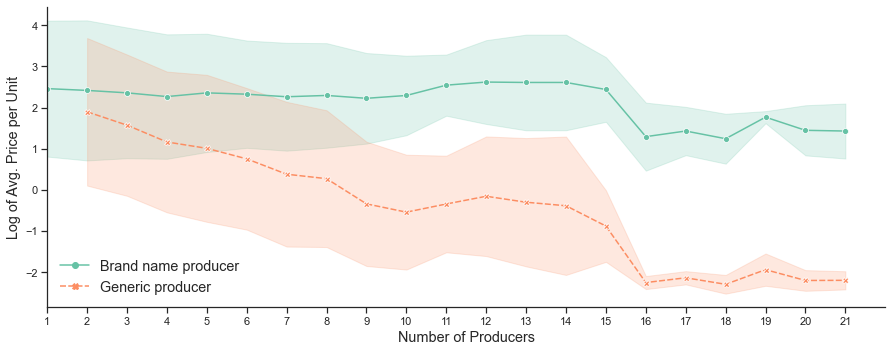

In [288]:
x = df_temp['running_count_generics'].max() # length of x-axis

fig = sns.relplot(data = df_temp, kind = 'line',
                  x = 'running_count_generics', y= 'ln_price_per_unit_adj',
                  hue = 'producer_type', style = 'producer_type', ci = 'sd', markers = True, facet_kws={'legend_out': False},
                  height = 5, aspect = 2.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

#plt.title('Price dynamics in the face of increasing competition')
plt.xlabel('Number of Producers', fontsize = 'large')
plt.ylabel('Log of Avg. Price per Unit', fontsize = 'large')
plt.legend(loc = 'lower left', frameon = False, fontsize = 'large')
plt.xticks(np.arange(1, x + 1, 1))

plt.xlim(left = 1)

plt.savefig('Log of Avg. Price per Unit for an increasing number of generic producers.png', bbox_inches = 'tight')
plt.show()

# Figure: Number of producers after second entrance

Import data

In [289]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [290]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')

Change the Time Event

In [291]:
df_temp = df_temp[df_temp['running_count_event'] >= 0]

Calculating the number of producers split between brand-name and genenic producers along with the avg. number of producers per unique drug

In [292]:
df_temp = df_temp.groupby(['running_count_event', 'producer_type'], as_index = False)[['labeler_name']].count()

df_temp = df_temp.pivot(index = 'running_count_event', columns = 'producer_type', values = ['labeler_name'])
df_temp = df_temp.droplevel(level = 1, axis = 1)
df_temp = df_temp.reset_index()
df_temp.columns = ['running_count_event','number_of_brand_name_producers','number_of_generic_producers']

df_temp['average_number_of_producers'] = df_temp['number_of_generic_producers'] / df_temp['number_of_brand_name_producers']

Plotting the figure

In [293]:
print(df_temp['running_count_event'].max())
print(df_temp['running_count_event'].min())

119.0
0.0


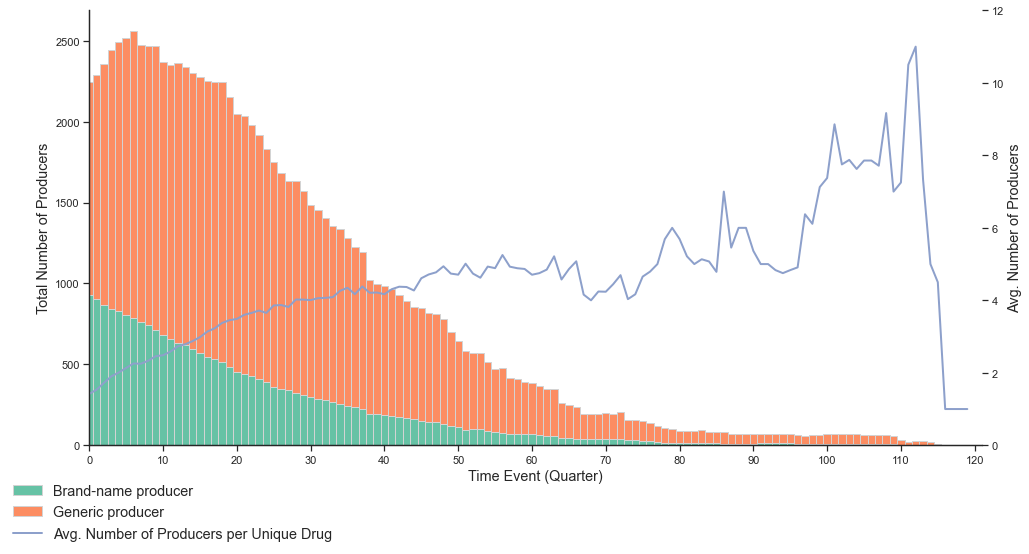

In [294]:
x_axis_max = df_temp['running_count_event'].max() # length of x-axis
x_axis_min = df_temp['running_count_event'].min() # length of x-axis
y = df_temp['average_number_of_producers'].max() # length of 2. y-axis

fig, ax = plt.subplots()

fig.set_figwidth(16)
fig.set_figheight(8)

set_width = 1

ax.bar(df_temp['running_count_event'], df_temp['number_of_brand_name_producers'], label = 'Brand-name producer', color = (0.4, 0.7607843137254902, 0.6470588235294118), edgecolor = 'lightgrey', width = set_width)
ax.bar(df_temp['running_count_event'], df_temp['number_of_generic_producers'], bottom = df_temp['number_of_brand_name_producers'], label = 'Generic producer', color = (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), edgecolor = 'lightgrey', width = set_width)
ax.set_ylabel('Total Number of Producers', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.2), loc = 'lower left', frameon = False, fontsize = 'large')
plt.xlabel('Time Event (Quarter)', fontsize = 'large')

ax = plt.twinx()
ax.plot(df_temp['running_count_event'], df_temp['average_number_of_producers'], '-', linewidth = 2.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = 'Avg. Number of Producers per Unique Drug')
ax.set_ylim(0, y + 1)
ax.set_ylabel('Avg. Number of Producers', fontsize = 'large')
ax.get_yticklines() # creating a line for the 2. y-axis
plt.legend(bbox_to_anchor = (-0.1, -0.25), loc = 'lower left', frameon = False, fontsize = 'large')

#plt.title('Number of producers from event')
plt.xticks(np.arange(x_axis_min, x_axis_max + 20, 10))
plt.xlim(left = x_axis_min) # white space
plt.xlim(right = x_axis_max + 2) # white space

plt.savefig('Number of producers over time event.png', bbox_inches = 'tight')
plt.show()

### Number of producers from event

In [295]:
df_temp.head()

,running_count_event,number_of_brand_name_producers,number_of_generic_producers,average_number_of_producers
0,0.0,929,1318,1.418730
1,1.0,902,1385,1.535477
2,2.0,865,1492,1.724855
3,3.0,841,1601,1.903686
4,4.0,829,1664,2.007238


# Figure: Price Dynamics before and after the event

Import data

In [296]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Creating a variable for producer type

In [297]:
df_temp = df

df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')

Calculating the avg. price split between brand-name and genenic producers

In [298]:
df_temp_price = df_temp.groupby(['running_count_event', 'producer_type', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp_price['ln_price_per_unit_adj'] = np.log(df_temp_price['price_per_unit_adj'])

Calculating the total quantity split between brand-name and genenic producers along with brand-name producers' share

In [299]:
df_temp_quantity = df_temp.groupby(['running_count_event', 'producer_type'], as_index = False)['units_reimbursed'].sum()

df_temp_quantity = df_temp_quantity.pivot(index = 'running_count_event', columns = 'producer_type', values = 'units_reimbursed')
df_temp_quantity = df_temp_quantity.reset_index()
df_temp_quantity.columns = ['running_count_event', 'units_reimbursed_brand_name_producers','units_reimbursed_generic_producers']

df_temp_quantity['units_reimbursed_generic_producers'] = df_temp_quantity['units_reimbursed_generic_producers'].fillna(0)

df_temp_quantity['units_reimbursed_brand_name_producers_share'] = ((df_temp_quantity['units_reimbursed_brand_name_producers']) / (df_temp_quantity['units_reimbursed_brand_name_producers'] + df_temp_quantity['units_reimbursed_generic_producers'])) * 100

Plotting figure

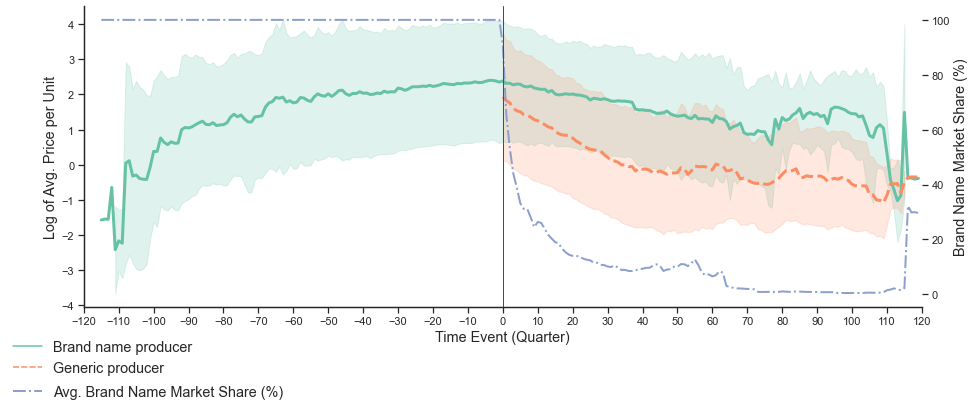

In [300]:
fig = sns.relplot(data = df_temp_price, kind = 'line', # Curves for avg. price
                  x = 'running_count_event', y= 'ln_price_per_unit_adj',
                  hue = 'producer_type', style = 'producer_type', linewidth = 3, ci = 'sd', markers = False, facet_kws={'legend_out': False},
                  height = 5, aspect = 2.5)
plt.xlabel('Time Event (Quarter)', fontsize = 'large')
plt.ylabel('Log of Avg. Price per Unit', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.27), loc = 'lower left', frameon = False, fontsize = 'large')
plt.xticks(np.arange(-115 - 5, 119 + 6, 10))
plt.xlim(left = -120) # white space
plt.xlim(right = 120) # white space

fig = plt.twinx() # Curves for total Quantity
fig.plot(df_temp_quantity['running_count_event'], df_temp_quantity['units_reimbursed_brand_name_producers_share'], '-.', linewidth = 2.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = "Avg. Brand Name Market Share (%)")
fig.set_ylabel('Brand Name Market Share (%)', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.35), loc = 'lower left', frameon = False, fontsize = 'large')

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

plt.axvline(0, color = "red", lw = 1, ls = '-')

#plt.title('Price dynamics over the event - one generic price')

plt.savefig('Price dynamics over the event - one generic price.png', format = 'png', bbox_inches = 'tight')
plt.show()

# Figure: Price Dynamics before and after the event (more producers)

df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])Import data

In [301]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Change the Time Event

In [302]:
df_temp = df

df_temp = df_temp[(df_temp['running_count_event'] >= -20) & (df_temp['running_count_event'] <= 40)]

Creating a variable for producer type

In [303]:
df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')

C:\Users\sebas\AppData\Local\Temp/ipykernel_9964/3575632896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['producer_type'] = df_temp['labeler_name_count'].apply(lambda x: 'Brand name producer' if x == 1 else 'Generic producer')


Splitting genenic producers based on the timing of entrance

In [304]:
df_temp_price = df_temp

df_temp_price['col_temp'] = 3

df_temp_price['labeler_name_count'] = df_temp_price['labeler_name_count'].astype('int') 
df_temp_price['labeler_name_count'] = df_temp_price['labeler_name_count'] - 1
df_temp_price['labeler_name_count'] = np.where(df_temp_price['labeler_name_count'] > df_temp_price['col_temp'], '3+', df_temp_price['labeler_name_count'])

df_temp_price['producer_type_count'] = df_temp_price['producer_type'].astype(str) + ': ' + df_temp_price['labeler_name_count'].astype(str)

df_temp_price['producer_type_count'] = df_temp_price['producer_type_count'].replace('Brand name producer: 0', 'Brand name producer')

C:\Users\sebas\AppData\Local\Temp/ipykernel_9964/2631944340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_price['col_temp'] = 3
C:\Users\sebas\AppData\Local\Temp/ipykernel_9964/2631944340.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_price['labeler_name_count'] = df_temp_price['labeler_name_count'].astype('int')
C:\Users\sebas\AppData\Local\Temp/ipykernel_9964/2631944340.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Calculating the avg. price split between brand-name and genenic producers

In [305]:
df_temp_price = df_temp_price.groupby(['running_count_event', 'producer_type_count', 'unique_id'], as_index = False)['price_per_unit_adj'].mean()

df_temp_price['ln_price_per_unit_adj'] = np.log(df_temp_price['price_per_unit_adj'])

Calculating the total quantity split between brand-name and genenic producers along with brand-name producers' share

In [306]:
df_temp_quantity = df_temp

df_temp_quantity = df_temp_quantity.groupby(['running_count_event', 'producer_type'], as_index = False)['units_reimbursed'].sum()

df_temp_quantity = df_temp_quantity.pivot(index = 'running_count_event', columns = 'producer_type', values = 'units_reimbursed')
df_temp_quantity = df_temp_quantity.reset_index()
df_temp_quantity.columns = ['running_count_event', 'units_reimbursed_brand_name_producers','units_reimbursed_generic_producers']

df_temp_quantity['units_reimbursed_generic_producers'] = df_temp_quantity['units_reimbursed_generic_producers'].fillna(0)

df_temp_quantity['units_reimbursed_brand_name_producers_share'] = ((df_temp_quantity['units_reimbursed_brand_name_producers']) / (df_temp_quantity['units_reimbursed_brand_name_producers'] + df_temp_quantity['units_reimbursed_generic_producers'])) * 100

Plotting figure

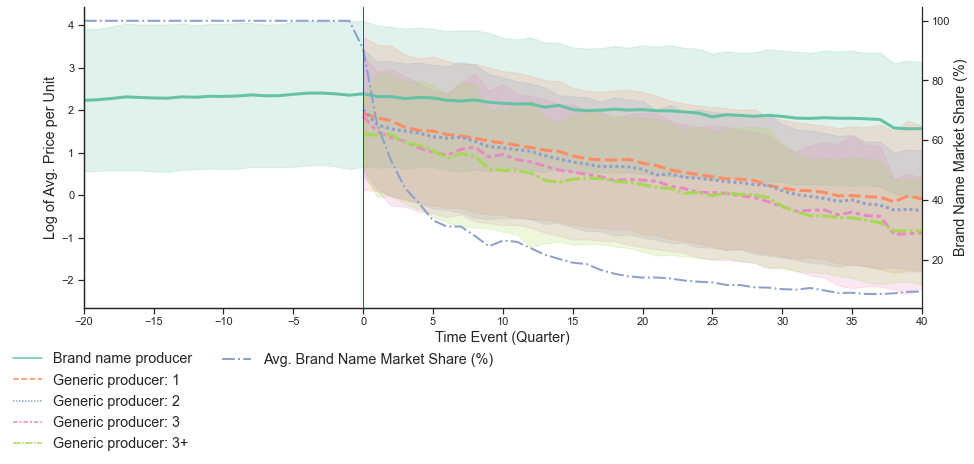

In [307]:
fig = sns.relplot(data = df_temp_price, kind = 'line', # Curves for avg. price
                  x = 'running_count_event', y= 'ln_price_per_unit_adj',
                  hue = 'producer_type_count', style = 'producer_type_count', ci = 'sd', linewidth = 3, markers = False, facet_kws={'legend_out': False},
                  height = 5, aspect = 2.5)


plt.xlabel('Time Event (Quarter)', fontsize = 'large')
plt.ylabel('Log of Avg. Price per Unit', fontsize = 'large')
plt.legend(bbox_to_anchor = (-0.1, -0.52), loc = 'lower left', frameon = False, fontsize = 'large')
plt.xticks(np.arange(-20, 40 + 5, 5))
plt.xlim(left = -20) # white space
plt.xlim(right = 40) # white space

fig = plt.twinx() # Curves for total Quantity
fig.plot(df_temp_quantity['running_count_event'], df_temp_quantity['units_reimbursed_brand_name_producers_share'], '-.', linewidth = 2.0, color = (0.5529411764705883, 0.6274509803921569, 0.796078431372549), label = "Avg. Brand Name Market Share (%)")
fig.set_ylabel('Brand Name Market Share (%)', fontsize = 'large')
plt.legend(bbox_to_anchor = (0.15, -0.24), loc = 'lower left', frameon = False, fontsize = 'large')

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc=custom_params)

plt.axvline(0, color = "red", lw = 1, ls = '-')

#plt.title('Price dynamics over the event - multiple generic prices')

plt.savefig('Price dynamics over the event - multiple generic prices.png', format = 'png', bbox_inches = 'tight')

plt.show()

# Specific drug figure

Import data

In [334]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df = df.dropna(subset = ['running_count_event'])

C:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Filtering on a specific drug and Time Event

In [335]:
df_temp = df
df_temp = df_temp.loc[df['unique_id'] == "olanzapine-tablet, orally disintegrating-oral-['5 mg/1']"]
df_temp = df_temp[df_temp['running_count_event'] >= -10]
df_temp = df_temp[['date', 'generic_name', 'labeler_name', 'price_per_unit_adj']]

Removing "," and "."

In [336]:
df_temp['labeler_name'] = df_temp['labeler_name'].apply(lambda x: x.replace(',', ''))
df_temp['labeler_name'] = df_temp['labeler_name'].apply(lambda x: x.replace('.', ''))

Change the format of datem

In [337]:
df_temp['date'] = pd.to_datetime(df_temp['date'])

Creating the data for price

In [338]:
df_temp['ln_price_per_unit_adj'] = np.log(df_temp['price_per_unit_adj'])

Plotting the figure

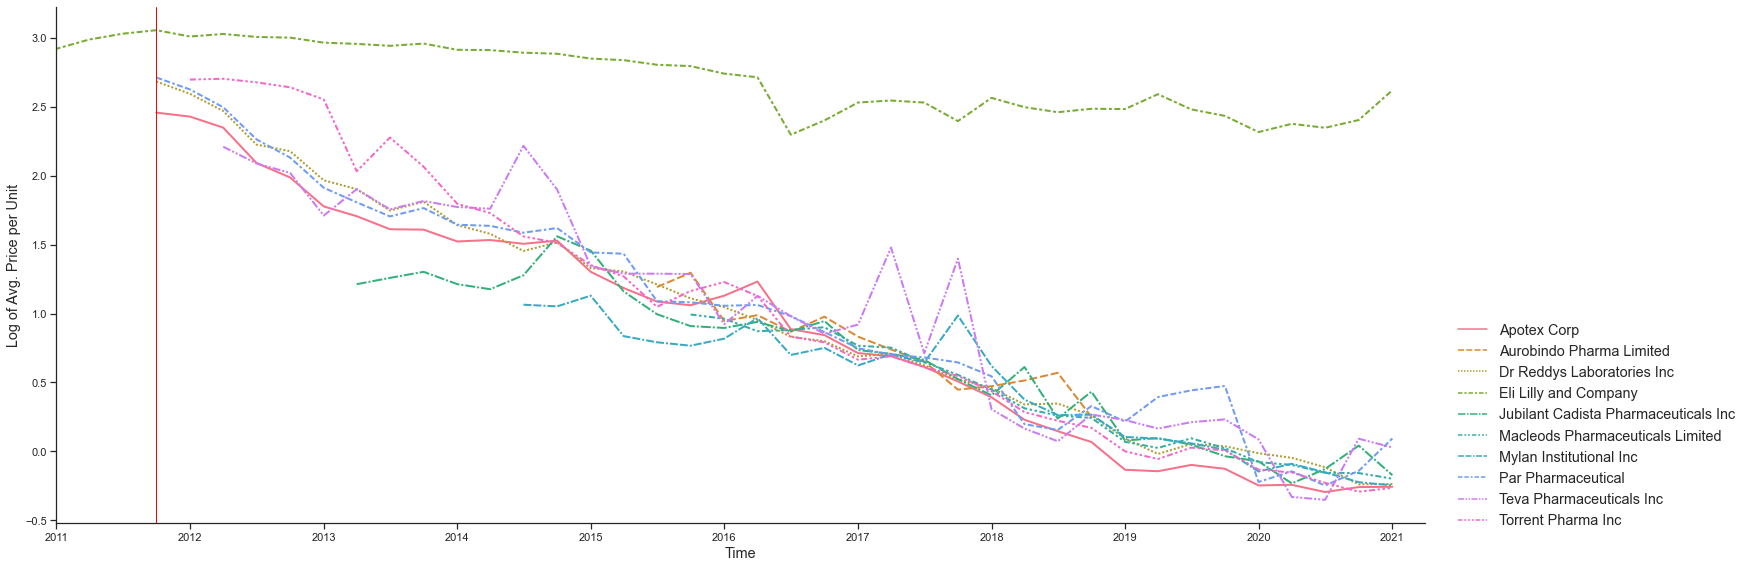

In [346]:
fig = sns.relplot(data = df_temp, kind = 'line', # Curves for avg. price
                  x = 'date', y= 'ln_price_per_unit_adj',
                  hue = 'labeler_name', style = 'labeler_name', linewidth = 2, markers = False, facet_kws={'legend_out': False},
                  height = 8, aspect = 2.5)

plt.xlabel('Time', fontsize = 'large')
plt.ylabel('Log of Avg. Price per Unit', fontsize = 'large')
plt.legend(loc=(1.02, -0.02), frameon = False, fontsize = 'large')

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style = 'ticks', palette = 'Set2', rc = custom_params)

plt.xlim(left = pd.Timestamp('01-01-2011')) # white space
plt.xlim(right = pd.Timestamp('04-01-2021')) # white space

plt.axvline(pd.Timestamp('10-01-2011'), color = "red", lw = 1, ls = '-')

#plt.title('Price dynamics over the time for Olanzapine (Zyprexa) - an antipsychotic drug')

plt.savefig('Price dynamics over the time for Olanzapine (Zyprexa) - an antipsychotic drug.png', format = 'png', bbox_inches = 'tight')

plt.show()

# Plotting beta values for first regression (model 1)

In [75]:
df = pd.read_excel('beta_values_for_model_1.xlsx')  

In [76]:
df.head()

,event2,coef sd t pv int1 int2
0,-20,-.0523262 .0239414 -2.19 0.029 -.0...
1,-19,-.0615297 .0273628 -2.25 0.025 -.1...
2,-18,-.0519025 .0281218 -1.85 0.065 -.1...
3,-17,-.0445286 .0295269 -1.51 0.132 -.1...
4,-16,-.0861871 .0324065 -2.66 0.008 -....


In [77]:
df_temp['  coef  sd  t  pv  int1   int2 '] = df['  coef  sd  t  pv  int1   int2 '].astype(str).apply(lambda x: re.sub("\s+", ",", x))
df_temp = df_temp['  coef  sd  t  pv  int1   int2 '].str.split(',', expand=True)
df = df['event2 ']
df = pd.merge(df, df_temp, left_index = True, right_index = True, how = 'left')

In [78]:
df = df.drop(columns = df.columns[[1, 3, 4, 5]])
df = df.rename({'event2 ': 'Event', 1: 'Coefficient', 5: 'Lower confidence interval', 6: 'Upper confidence interval'}, axis='columns')
df = df['Coefficient'].astype('int64')

ValueError: invalid literal for int() with base 10: '-.0523262'

In [63]:
df.head()

,Event,Coefficient,Lower confidence interval,Upper confidence interval
0,-20,-.0523262,-.0993084,-.0053441
1,-19,-.0615297,-.1152259,-.0078334
2,-18,-.0519025,-.1070883,.0032832
3,-17,-.0445286,-.1024717,.0134144
4,-16,-.0861871,-.149781,-.0225932


TypeError: 'value' must be an instance of str or bytes, not a None

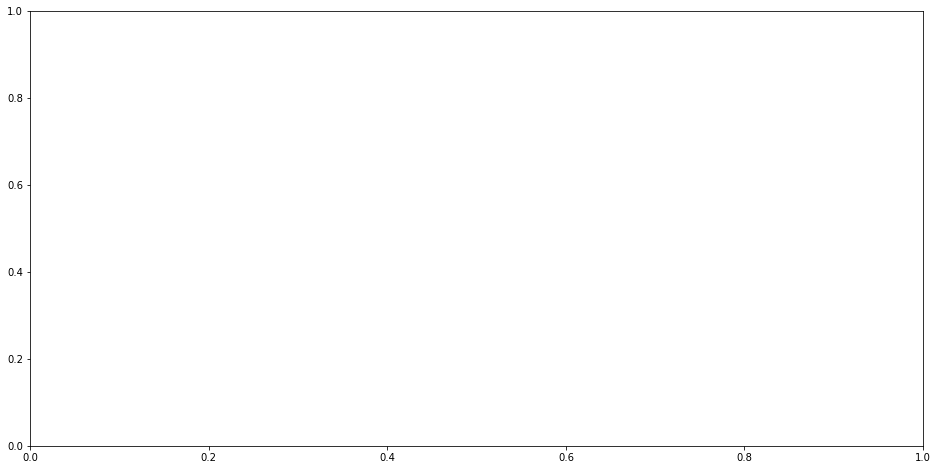

In [65]:
fig, ax = plt.subplots()

fig.set_figwidth(16)
fig.set_figheight(8)

#set_width = 1

plt.scatter(df['Event'], df['Coefficient'], c ="blue")


#plt.savefig('x.png', bbox_inches = 'tight')
plt.show()